# WGAN Version

#### Imports

In [79]:
# imports
import os
import pandas as pd
import random
import tensorflow as tf
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,Activation, LeakyReLU, BatchNormalization, Conv2DTranspose, Reshape, Input, InputLayer
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
import pathlib
import tensorflow_addons as tfa
import sys
from PIL import Image


#### Default Values

In [80]:
# DATASET VALUES
BATCH_SIZE = 256
DATASET_DIRECTORY = "./dataset/cropped/"
IMAGE_SIZE = 64
REMOVED = True

# MODEL VALUES
NOISE_DIM = 128
KERNEL_SIZE = 4
STRIDES = 2

# TRAIN VALUES
EPOCHS = 50


#### Loading dataset

In [81]:
# This dataset has a small problem, there are some corrupted images with a filesize of 0 bytes, so we need to remove them...
if not REMOVED:
    for root, dirs, files in os.walk("dataset"):
      for file in files:
        path = os.path.join(root, file)
        if os.stat(path).st_size == 0:
          print("Removing file:", path)
          os.remove(path)

In [82]:
# Loading dataset
# Every image will be converted to 64x64, making sure they are all the same size
dataset = tf.keras.preprocessing.image_dataset_from_directory(DATASET_DIRECTORY, label_mode = None, image_size = (IMAGE_SIZE,IMAGE_SIZE) , batch_size=BATCH_SIZE)

# Normalize the dataset
dataset = dataset.map(lambda x: (x) /255)

Found 63569 files belonging to 1 classes.


#### Some images from dataset

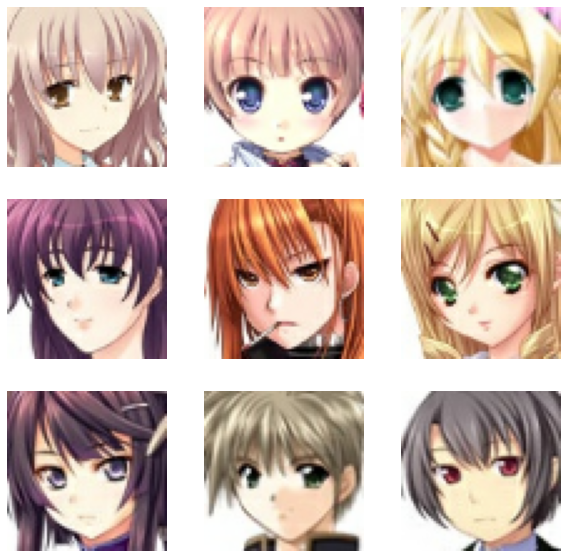

In [83]:
plt.figure(figsize=(10, 10))
for images in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis("off")


#### Model
In the original WGAN, discriminator is called critic

In [84]:
critic = tf.keras.Sequential()
critic.add(tf.keras.layers.Conv2D(32, kernel_size=KERNEL_SIZE, strides=STRIDES, padding="same", input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
critic.add(LeakyReLU())

critic.add(tf.keras.layers.Conv2D(64, kernel_size=KERNEL_SIZE, strides=STRIDES, padding="same"))
critic.add(LeakyReLU())

critic.add(tf.keras.layers.Conv2D(64, kernel_size=KERNEL_SIZE, strides=STRIDES, padding="same"))
critic.add(LeakyReLU())

critic.add(Flatten())
critic.add(Dense(1,activation="linear"))

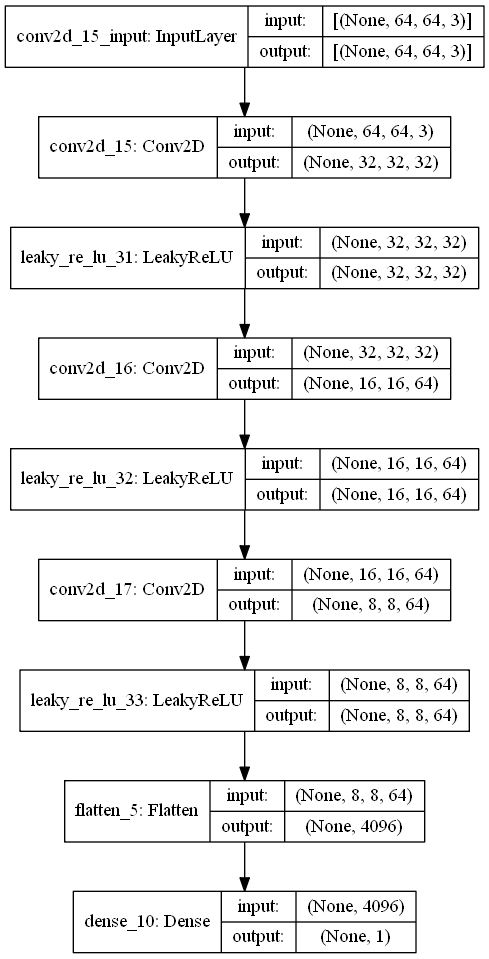

In [85]:
tf.keras.utils.plot_model(critic, show_shapes=True)

In [86]:
# Generator Model
generator = tf.keras.Sequential()

generator.add(Dense(4*4*256, input_dim=NOISE_DIM))
generator.add(LeakyReLU())

generator.add(Reshape((4, 4, 256)))

generator.add(Conv2DTranspose(128, kernel_size=KERNEL_SIZE, strides=STRIDES,padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU())

generator.add(Conv2DTranspose(64, kernel_size=KERNEL_SIZE, strides=STRIDES, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU())

generator.add(Conv2DTranspose(32, kernel_size=KERNEL_SIZE, strides=STRIDES, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU())


generator.add(Conv2DTranspose(3, kernel_size=KERNEL_SIZE, strides=STRIDES, padding='same', activation='tanh'))


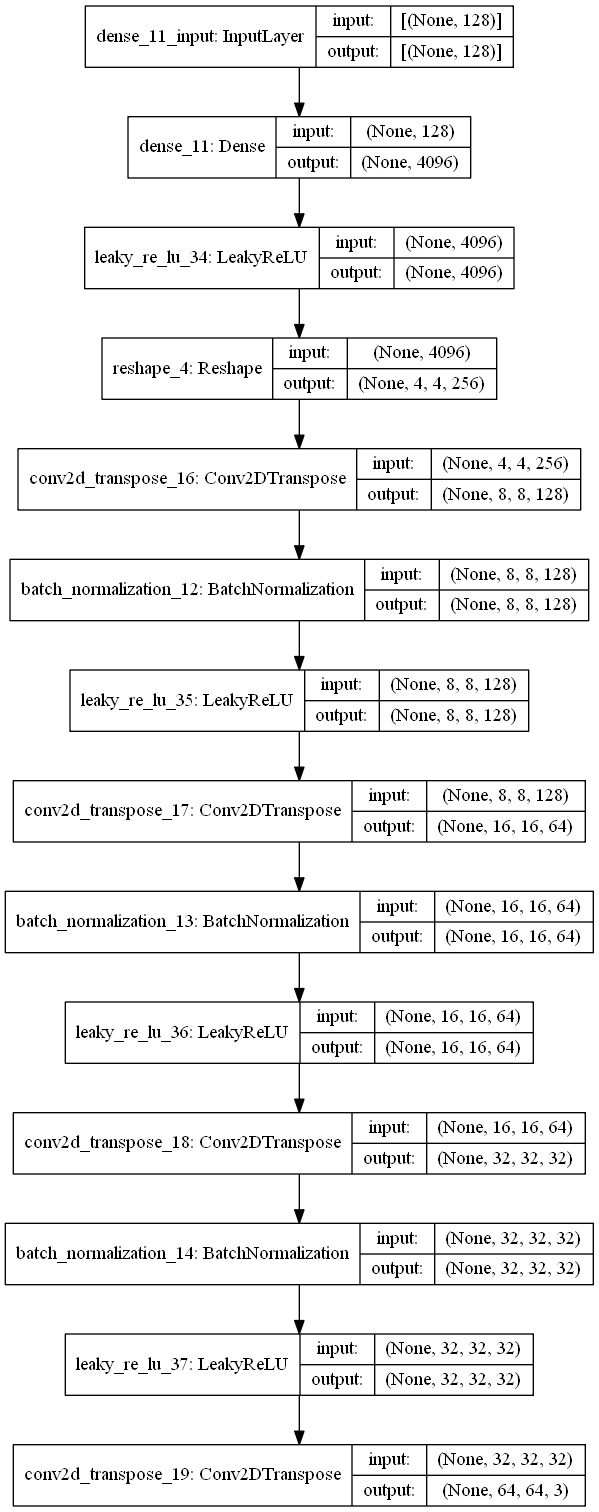

In [87]:
tf.keras.utils.plot_model(generator, show_shapes=True)

#### Creating WGAN Class

The code comes from: https://keras.io/examples/generative/wgan_gp/#create-the-discriminator-the-critic-in-the-original-wgan , with some small changes.

For each batch:
1. Generator and Discriminator/Critic are trained and then we calculate the both loss;
2. We calculate gradient penalty
3. Multiply this penalty with a constant weight factor
4. Add penalty to the discriminator/critic loss
5. Return generator and discriminator/critic as loss dictionary
 

In [88]:
class WGAN(tf.keras.Model):
    def __init__(self, critic, generator, latent_dim, critic_extra_steps): 
        super().__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.c_extra_steps = critic_extra_steps
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        for i in range(self.c_extra_steps):
            with tf.GradientTape() as tape:
                # generating predictions based on real images
                pred_real = self.critic(real_images, training=True)

                # generating fake images  from noise
                fake_images = self.generator(noise, training=True) 

                # generating predictions based on fake images
                pred_fake = self.critic(fake_images, training=True)
                
                # Calculating the loss
                d_loss = self.d_loss_fn(pred_real, pred_fake)
                
            # Calculating gradient 
            grads = tape.gradient(d_loss, self.critic.trainable_variables)
            self.d_optimizer.apply_gradients(zip(grads, self.critic.trainable_variables))

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.critic(fake_images, training=True)
            g_loss = self.g_loss_fn(pred_fake) 

        # Calculating gradient   
        grads = tape.gradient(g_loss, self.generator.trainable_variables)

        # Update 
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [89]:
# Wasserstein loss for the critic
def d_wasserstein_loss(pred_real, pred_fake):
    real_loss = tf.reduce_mean(pred_real)
    fake_loss = tf.reduce_mean(pred_fake)
    return fake_loss - real_loss

# Wasserstein loss for the generator
def g_wasserstein_loss(pred_fake):
    return -tf.reduce_mean(pred_fake)

#### Optimizers

In [90]:
generator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

In [91]:
wgan = WGAN(
    critic=critic,
    generator=generator,
    latent_dim=NOISE_DIM,
    critic_extra_steps=3,
)

In [92]:
wgan.compile(
    d_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00002, clipvalue=1.0, decay=1e-8), 
    g_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00002, clipvalue=1.0, decay=1e-8), 
    d_loss_fn = d_wasserstein_loss,
    g_loss_fn = g_wasserstein_loss
)

In [93]:
wgan.fit(dataset, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/50
249/249 [==============================] - 74s 277ms/step - d_loss: -189.5314 - g_loss: -158.7919
Epoch 2/50
249/249 [==============================] - 65s 261ms/step - d_loss: -1756.4604 - g_loss: -4945.5054
Epoch 3/50
249/249 [==============================] - 65s 261ms/step - d_loss: -2443.5486 - g_loss: -26379.2461
Epoch 4/50
249/249 [==============================] - 65s 261ms/step - d_loss: 62.0237 - g_loss: -32147.8027
Epoch 5/50
249/249 [==============================] - 65s 261ms/step - d_loss: 699.0718 - g_loss: -10340.7246
Epoch 6/50
249/249 [==============================] - 66s 261ms/step - d_loss: 197.9997 - g_loss: -1739.7673
Epoch 7/50
249/249 [==============================] - 66s 262ms/step - d_loss: 17.3131 - g_loss: -204.0571
Epoch 8/50
249/249 [==============================] - 66s 261ms/step - d_loss: -1.6431 - g_loss: -11.9808
Epoch 9/50
249/249 [==============================] - 66s 261ms/step - d_loss: -3.6939 - g_loss: -4.5089
Epoch 10/50
249/249 [=

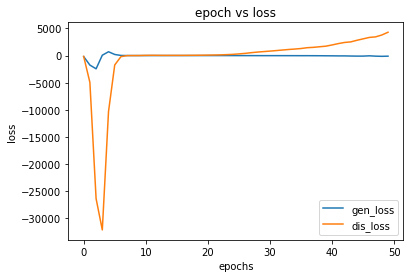

In [104]:
x = [X for X in range(EPOCHS)]
plt.plot(x, wgan.history.history['d_loss'], label="Discriminator loss")
plt.plot(x,wgan.history.history['g_loss'], label="Generator loss")
plt.title('epoch vs loss')
plt.legend(['gen_loss','dis_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [99]:
num = np.random.randn(32,128)
pred = generator.predict(num)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

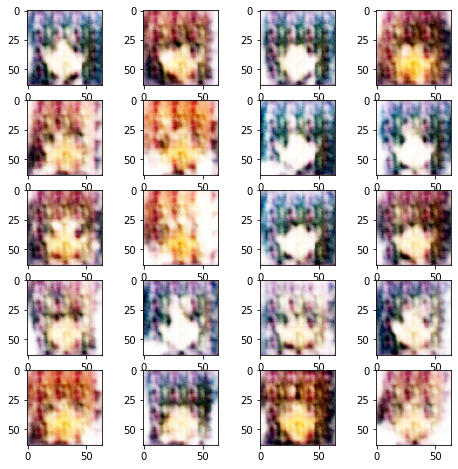

In [100]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(pred[i])
plt.show()

#### Some results using this model


- 10 epochs

![<10 epochs>](wgan_results/10_epochs.png)

- 20 epochs

![<20 epochs>](wgan_results/20_epochs.png)

- 50 epochs

![<50 epochs>](wgan_results/50_epochs.png)